In [4]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()


True

In [5]:
llm = ChatGroq(
    model_name="gemma2-9b-it",
    api_key=os.getenv("GROQ_API_KEY"),
)

In [7]:
llm.invoke(
    "What is the capital of France?",
).content

'The capital of France is **Paris**. 🇫🇷  \n'

In [83]:
import operator
from typing import List, Dict, Any, TypedDict, Annotated, Optional, Union, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [65]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm.invoke(question)
    return {"messages": [response]}

In [66]:
call_model(
    {
        "messages": [
            "What is the capital of France?"
        ]
    }
)

{'messages': [AIMessage(content='The capital of France is **Paris**. 🇫🇷  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_time': 0.027272727, 'prompt_time': 0.001948206, 'queue_time': 0.242838204, 'total_time': 0.029220933}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c41333f-fe6a-4aaa-b6af-9fe67e45cd04-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31})]}

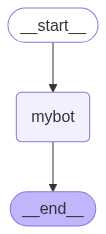

In [67]:
workflow = StateGraph(MessagesState)

workflow.add_node("mybot", call_model)

workflow.add_edge(START, "mybot")
workflow.add_edge("mybot", END)

app = workflow.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [68]:
app.invoke(
    {
        "messages": [
            "What is the capital of France?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='23c1c43f-bcc7-49d4-91f1-baec17de181c'),
  AIMessage(content='The capital of France is **Paris**. 🗼 🇫🇷  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 16, 'total_tokens': 33, 'completion_time': 0.030909091, 'prompt_time': 0.001906427, 'queue_time': 0.24918070200000003, 'total_time': 0.032815518}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--caddc28d-ab23-432b-a6be-641a8794f71f-0', usage_metadata={'input_tokens': 16, 'output_tokens': 17, 'total_tokens': 33})]}

### Tools

In [70]:
@tool
def search(query: str) -> str:
    """This is a custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temperature in Delhi is 30 degrees Celsius"
    return "The temperature is 25 degrees Celsius in the city you asked about."

In [71]:
search.invoke("What is the weather in Delhi?")

'the temperature in Delhi is 30 degrees Celsius'

In [72]:
search.invoke("What is the weather in Mumbai?")

'The temperature is 25 degrees Celsius in the city you asked about.'

#### Binding tools

In [84]:
tools=[search]

In [90]:
tool_node = ToolNode(tools)

In [92]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is a custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x12cf07400>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [91]:
search

StructuredTool(name='search', description='This is a custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x12cf07400>)

In [86]:
llm_with_tools = llm.bind_tools(tools)


In [87]:
response = llm_with_tools.invoke(
    "What is the weather in Delhi?"
)

In [88]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'v9txqfp61',
  'type': 'tool_call'}]

In [79]:
def call_model_with_tools(state: MessagesState):
    question = state['messages']
    response = llm_with_tools.invoke(question)
    return {"messages": [response]}

In [80]:
call_model_with_tools(
    {
        "messages": [
            "What is the weather in Delhi?"
        ]
    }
)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5zakpj7fs', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 946, 'total_tokens': 1028, 'completion_time': 0.149090909, 'prompt_time': 0.033180804, 'queue_time': 0.25176967499999997, 'total_time': 0.182271713}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eee477a1-b326-4a90-8f67-7c3db99df7e6-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '5zakpj7fs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 82, 'total_tokens': 1028})]}

In [103]:
def router_function(state: MessagesState):
    lst_msg = state['messages'][-1]
    if lst_msg.tool_calls:
        return "tools"
    return END

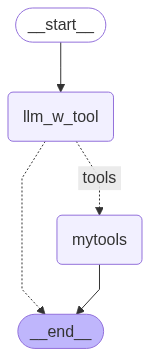

In [104]:
workflow_with_tools = StateGraph(MessagesState)

workflow_with_tools.add_node("llm_w_tool", call_model_with_tools)
workflow_with_tools.add_node("mytools",  tool_node)

workflow_with_tools.add_edge(START, "llm_w_tool")
workflow_with_tools.add_conditional_edges(
    "llm_w_tool",
    router_function,
    {
        "tools": "mytools",
        END: END
    }
)

app_with_tools = workflow_with_tools.compile()

display(Image(app_with_tools.get_graph().draw_mermaid_png()))

In [105]:
app_with_tools.invoke(
    {
        "messages": [
            "What is the weather in Delhi?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the weather in Delhi?', additional_kwargs={}, response_metadata={}, id='b82b8b7d-27df-4480-9865-75cdbf1bc806'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '213bfjegd', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 946, 'total_tokens': 1028, 'completion_time': 0.149090909, 'prompt_time': 0.044498297, 'queue_time': 0.252341378, 'total_time': 0.193589206}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c12a1d84-df33-4542-afcb-00dd9ad500a0-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '213bfjegd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 82, 'total_tokens': 1028}),
  ToolMessage(content='the temperature in Delhi is 30 degrees Celsius', name='search

In [106]:
app_with_tools.invoke(
    {
        "messages": [
            "What is the weather in Mumbai?"
        ]
    }
)

{'messages': [HumanMessage(content='What is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='ffe1fc04-8c4e-41ed-88da-fb8bacf5aa71'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k9m738396', 'function': {'arguments': '{"query":"weather in Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 946, 'total_tokens': 1028, 'completion_time': 0.149090909, 'prompt_time': 0.033137181, 'queue_time': 0.24295824099999996, 'total_time': 0.18222809}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d537d04b-5294-4776-861e-7c0fcb101246-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Mumbai'}, 'id': 'k9m738396', 'type': 'tool_call'}], usage_metadata={'input_tokens': 946, 'output_tokens': 82, 'total_tokens': 1028}),
  ToolMessage(content='The temperature is 25 degrees Celsius in the city y

In [107]:
app_with_tools.invoke(
    {
        "messages": [
            "What is capital of France?"
        ]
    }
)

{'messages': [HumanMessage(content='What is capital of France?', additional_kwargs={}, response_metadata={}, id='d4704d1b-7508-489e-8def-32d116853694'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'd1f88sbpj', 'function': {'arguments': '{"query":"capital of France"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 945, 'total_tokens': 1025, 'completion_time': 0.145454545, 'prompt_time': 0.033037242, 'queue_time': 0.24536936700000003, 'total_time': 0.178491787}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6ca38817-a830-4d89-abb0-05a5cb2d8470-0', tool_calls=[{'name': 'search', 'args': {'query': 'capital of France'}, 'id': 'd1f88sbpj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 945, 'output_tokens': 80, 'total_tokens': 1025}),
  ToolMessage(content='The temperature is 25 degrees Celsius in the city you 